In [2]:
import os
import time
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, stft
from scipy.fft import fft
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve 

In [61]:
def cria_curva_roc_auc(modelo,df_verificacao,df_target):
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions[:,1]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS')
    plt.legend(loc="lower right")
    plt.show()
    
def limiar_escore(modelo,df_verificacao,df_target):
    #Imprimindo limiar de Escore
    predictions = modelo.predict(df_verificacao)
    fpr, tpr, threshold = roc_curve(df_target, predictions[:,1])
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions[:,1]]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)
    print('Roc-AUC', roc_auc_score(df_target, predictions[:,1]))

# Functions

In [4]:
def plot_eeg(df, name='', save=False):
    fig, rows = plt.subplots(nrows=4, sharex=True, figsize=(17,10))
    fig.patch.set_visible(False)
    fig.tight_layout()

    for ax, col in zip(rows, df.columns):
        ax.plot(df[col])
        ax.title.set_text(col + "_" + name)
        ax.set_ylim(-150, 150)
        ax.patch.set_visible(False)
        
    if not save:
        plt.show()
    else:
        plt.savefig(f'figs/{name}.png')
        plt.close(fig)

In [5]:
def coluniza(a, nome):
    d = pd.DataFrame(a).T
    d.columns = [nome + "_" + str(col) for col in d.columns]
    return d

In [6]:
def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)


def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
folder = './Data'

In [9]:
%%time
chunks = []
for f in os.listdir(folder):
    print(f)
    if 'Full_Negatives_7nov' in f:
        chunk = pd.read_hdf(os.path.join(folder, f))
        chunks.append(chunk)
neg = pd.concat(chunks, axis=0)

Full_Positives_7nov.hdf
Full_Negatives_7nov0.hdf
Full_Negatives_7nov2.hdf
Full_Negatives_7nov1.hdf
CPU times: user 17.2 s, sys: 18.5 s, total: 35.6 s
Wall time: 35.6 s


In [10]:
neg.columns

Index(['File', 'Paciente', 'Data', 'timestamp_start', 'Target'], dtype='object')

In [11]:
neg.shape

(30000, 5)

In [12]:
neg.head()

,File,Paciente,Data,timestamp_start,Target
0,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1-...,0,1
1,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,9000,1
2,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,18000,1
3,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,27000,1
4,danila_ramos.edf,RN DALILA RAMOS DOMINGUES,EEG C3-P3 EEG C4-P4 EEG P3-P4 EEG A1...,36000,1


In [13]:
neg['Data'].values[0]

,EEG C3-P3,EEG C4-P4,EEG P3-P4,EEG A1-A2
0,0.083503,-0.194469,-0.320255,0.093475
1,0.627561,-1.572063,-2.581153,0.856685
2,2.441086,-6.431905,-10.524846,3.505472
3,6.657532,-17.835315,-29.223078,9.768281
4,14.455691,-38.728811,-63.442064,21.216426
...,...,...,...,...
5995,7.382942,-8.689627,-5.391998,8.690808
5996,8.153691,-8.957492,-5.147577,9.117308
5997,8.697748,-8.880959,-4.597629,9.386676
5998,8.879101,-8.306962,-3.742154,9.341781


In [14]:
#Esqueci do target 0 rs
neg['Target'] = 0

In [15]:
pos = pd.read_hdf(os.path.join(folder, "Full_Positives_7nov.hdf"))

In [16]:
pos.shape, neg.shape

((1540, 5), (30000, 5))

In [17]:
#junta em um df
df = pd.concat([neg, pos]).reset_index(drop=True)

In [18]:
df['Target'].value_counts(dropna=False)

0    30000
1     1540
Name: Target, dtype: int64

In [19]:
#janelas de crise (alguns bebes tem muito pouco, não são usados para validar)
pos['File'].value_counts()

fabiana_1.edf           646
gilmara_cristina.edf    357
murilo_1.edf            211
remise_jean.edf          94
danila_ramos_4.edf       85
sarah_jadach.edf         84
danila_ramos.edf         56
juliana_lima_1.edf        5
juliana_lima_2.edf        1
marilene.edf              1
Name: File, dtype: int64

In [20]:
#janelas de não crise
df['File'].value_counts()

murilo_1.edf            11234
danila_ramos_5.edf       5550
danila_ramos_4.edf       3755
marilene.edf             2946
remise_jean.edf          2911
juliana_lima_2.edf       1945
fabiana_1.edf            1120
gilmara_cristina.edf      784
danila_ramos.edf          657
juliana_lima_1.edf        503
sarah_jadach.edf           84
danila_ramos_3.edf         51
Name: File, dtype: int64

# Testando em tudo
Sinais de 4 canais, 6000 amostras, frequencia = 200/sec

In [21]:
df['Data'].values[0].columns

Index(['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2'], dtype='object')

In [22]:
dictStftArrayFinal = {}

In [24]:
from tqdm import tqdm

In [25]:
fs = 200 # Hz
n = 5*fs # 5 seg

In [27]:
%%time
for bb in df['File'].unique():
    
    stftArrayFinal = None
    tgt = None
    
    for i,row in tqdm(df[df['File'] == bb].reset_index(drop=True).iterrows()):

        subDf = row['Data']
        dfArray = []
        #print(row['File'])

        for col in ['EEG C3-P3', 'EEG C4-P4', 'EEG P3-P4', 'EEG A1-A2']:

            #print(col)
            #print('Min:', np.min(np.abs(subDf[col].values)),'Max:', np.max(np.abs(subDf[col].values)))


            signalz = subDf[col].values/np.max(np.abs(subDf[col].values))
            signalz = butter_bandpass_filter(signalz, 0.5, 75, fs, order=6)
            dfArray.append(signalz)

        #print(' --- ')

        stftArray = []
        target = []

        for array in dfArray:

            subArray = [np.abs(np.fft.rfft(array[i:i + n]))/np.max(np.abs(np.fft.rfft(array[i:i + n]))) for i in range(0, len(array), n) if len(array[i:i + n]) == n]

            stftArray.append(np.array(subArray))

        stftArray = np.array(stftArray)

        if row['Target'] == 0:
            tar = np.ones((stftArray.shape[1],))
        else:
            tar = np.zeros((stftArray.shape[1],))

        if i == 0:
            stftArrayFinal = stftArray.copy()
            tgt = tar.copy()
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal,stftArray),axis=1)
            tgt = np.concatenate((tgt,tar),axis=0)
            
    arrayt = []
    for t in tgt:
        if t == 0:
            arrayt.append([0,1])
        else:
            arrayt.append([1,0])

    tgt  = np.array(arrayt)
    
    stftArrayFinal = np.expand_dims(np.swapaxes(np.swapaxes(stftArrayFinal,0,1),1,2),axis=3)
    
    dictStftArrayFinal[bb] = { 'array' : stftArrayFinal, 'target' : tgt }

657it [00:08, 76.42it/s] 
51it [00:00, 262.43it/s]
3755it [04:18, 14.54it/s]
5550it [09:24,  9.82it/s]
1120it [00:22, 50.00it/s]
11234it [38:12,  4.90it/s]
2911it [02:33, 18.96it/s]
784it [00:11, 68.67it/s] 
503it [00:04, 106.12it/s]
1945it [01:05, 29.61it/s]
2946it [02:37, 18.73it/s]
84it [00:00, 255.85it/s]

CPU times: user 29min 48s, sys: 29min 21s, total: 59min 10s
Wall time: 59min


In [28]:
save_to_file(dictStftArrayFinal, 'dictStftArrayFinal.pkl')

## Model

In [29]:
del df, neg, pos

In [30]:
del subDf

In [31]:
import gc
gc.collect()

160

# Neural Network

In [32]:
dictStftArrayFinal.keys()

dict_keys(['danila_ramos.edf', 'danila_ramos_3.edf', 'danila_ramos_4.edf', 'danila_ramos_5.edf', 'fabiana_1.edf', 'murilo_1.edf', 'remise_jean.edf', 'gilmara_cristina.edf', 'juliana_lima_1.edf', 'juliana_lima_2.edf', 'marilene.edf', 'sarah_jadach.edf'])

In [12]:
dictStftArrayFinal = load_file('dictStftArrayFinal.pkl')

# Treino em Todos Menos  "murilo_1.edf"

In [37]:
tgt = None
stftArrayFinal = None

In [38]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'murilo_1.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [39]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(121836, 501, 4, 1)

In [40]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 1), 2)

In [41]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(4, 1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(1, 4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [42]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 501, 4, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 249, 4, 640)       3200      
_________________________________________________________________
activation (Activation)      (None, 249, 4, 640)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 83, 4, 640)        0         
_________________________________________________________________
dropout (Dropout)            (None, 83, 4, 640)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 1, 640)        1639040   
_________________________________________________________________
activation_1 (Activation)    (None, 83, 1, 640)       

In [44]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy', 'AUC'])

In [45]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_murilo.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['murilo_1.edf']['array'], dictStftArrayFinal['murilo_1.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
476/476 [==============================] - 319s 670ms/step - loss: 0.3091 - accuracy: 0.9029 - auc: 0.9471 - val_loss: 0.1026 - val_accuracy: 0.9793 - val_auc: 0.9883
Epoch 2/300
476/476 [==============================] - 324s 680ms/step - loss: 0.1161 - accuracy: 0.9637 - auc: 0.9901 - val_loss: 0.4292 - val_accuracy: 0.8888 - val_auc: 0.9240
Epoch 3/300
476/476 [==============================] - 327s 688ms/step - loss: 0.0947 - accuracy: 0.9679 - auc: 0.9936 - val_loss: 0.0971 - val_accuracy: 0.9734 - val_auc: 0.9933
Epoch 4/300
476/476 [==============================] - 328s 689ms/step - loss: 0.0850 - accuracy: 0.9712 - auc: 0.9947 - val_loss: 0.0623 - val_accuracy: 0.9821 - val_auc: 0.9970
Epoch 5/300
476/476 [==============================] - 324s 680ms/step - loss: 0.0807 - accuracy: 0.9718 - auc: 0.9952 - val_loss: 0.1020 - val_accuracy: 0.9706 - val_auc: 0.9921
Epoch 6/300
476/476 [==============================] - 328s 689ms/step - loss: 0.0748 - accuracy: 0.9737 

In [46]:
model.save_weights("./modelo_murilo.hdf5")

In [76]:
model.load_weights('./bestAutoSave_murilo.hdf5')

In [77]:
y_pred = model.predict(dictStftArrayFinal['murilo_1.edf']['array'])

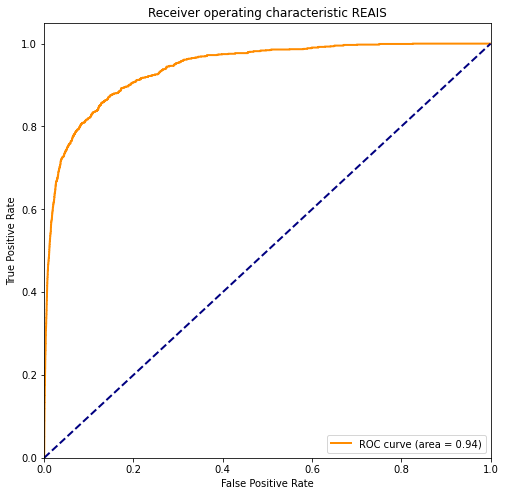

In [62]:
cria_curva_roc_auc(model,dictStftArrayFinal['murilo_1.edf']['array'],dictStftArrayFinal['murilo_1.edf']['target'][:,1])

In [64]:
limiar_escore(model,dictStftArrayFinal['murilo_1.edf']['array'],dictStftArrayFinal['murilo_1.edf']['target'][:,1])

Limiar que maxima especificidade e sensitividade:
[0.013873755931854248]
Precision 0.10774842271293375
Recall 0.863349131121643
Acuracia 0.8631535220461694
F-Score 0.1915863277826468
Roc-AUC 0.9413874357780421


In [78]:
confusion_matrix(dictStftArrayFinal['murilo_1.edf']['target'][:,1], [1 if x >= 0.1 else 0 for x in y_pred[:,1]])

array([[64059,  2079],
       [  400,   866]])

# Treino em Todos Menos  "remise_jean.edf"

In [79]:
tgt = None
stftArrayFinal = None

In [80]:
for i,bb in enumerate(dictStftArrayFinal.keys()):
    
    if bb != 'remise_jean.edf':
    
        if i == 0:
            
            tgt = dictStftArrayFinal[bb]['target'].copy()
            stftArrayFinal = dictStftArrayFinal[bb]['array'].copy()
            
        else:
            stftArrayFinal = np.concatenate((stftArrayFinal, dictStftArrayFinal[bb]['array']))
            tgt = np.concatenate((tgt, dictStftArrayFinal[bb]['target']))

In [81]:
#(10816, 201, 5, 1)
stftArrayFinal.shape

(171774, 501, 4, 1)

In [82]:
#input_shape = (img_rows, img_cols, 1)
input_shape = stftArrayFinal[0].shape
num_classes = 2
batch_size = 256
epochs = 300 #600
input_shape,num_classes

((501, 4, 1), 2)

In [83]:
# CRIANDO MODELO
inp = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(4, 1), strides=(2, 1))(inp)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 1))(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Conv2D(32*20, kernel_size=(1, 4), strides=(1, 1))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)
#
#
#
eeg = tf.keras.layers.Dense(num_classes,activation='softmax',name='output')(x)

model = tf.keras.models.Model(inputs=inp,outputs=[eeg])

In [84]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 501, 4, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 249, 4, 640)       3200      
_________________________________________________________________
activation_2 (Activation)    (None, 249, 4, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 83, 4, 640)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 83, 4, 640)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 83, 1, 640)        1639040   
_________________________________________________________________
activation_3 (Activation)    (None, 83, 1, 640)       

In [85]:
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy', 'AUC'])

In [86]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('bestAutoSave_remise.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    stftArrayFinal, tgt,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(dictStftArrayFinal['remise_jean.edf']['array'], dictStftArrayFinal['remise_jean.edf']['target']),
    callbacks=[mcp_save, earlyStopping],
    verbose=1
)

Epoch 1/300
671/671 [==============================] - 360s 536ms/step - loss: 0.2451 - accuracy: 0.9136 - auc: 0.9666 - val_loss: 0.1810 - val_accuracy: 0.9457 - val_auc: 0.9821
Epoch 2/300
671/671 [==============================] - 359s 535ms/step - loss: 0.0723 - accuracy: 0.9759 - auc: 0.9959 - val_loss: 0.1310 - val_accuracy: 0.9634 - val_auc: 0.9881
Epoch 3/300
671/671 [==============================] - 353s 526ms/step - loss: 0.0594 - accuracy: 0.9783 - auc: 0.9972 - val_loss: 0.2519 - val_accuracy: 0.9198 - val_auc: 0.9726
Epoch 4/300
671/671 [==============================] - 352s 524ms/step - loss: 0.0538 - accuracy: 0.9804 - auc: 0.9976 - val_loss: 1.4483 - val_accuracy: 0.3667 - val_auc: 0.3603
Epoch 5/300
671/671 [==============================] - 351s 524ms/step - loss: 0.0498 - accuracy: 0.9815 - auc: 0.9978 - val_loss: 0.5345 - val_accuracy: 0.7100 - val_auc: 0.8096
Epoch 6/300
671/671 [==============================] - 351s 523ms/step - loss: 0.0467 - accuracy: 0.9825 

In [87]:
model.save_weights("./modelo_remise.hdf5")

In [88]:
model.load_weights('./bestAutoSave_remise.hdf5')

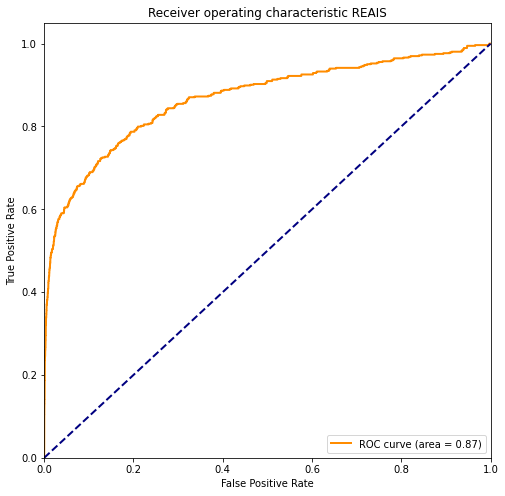

In [90]:
cria_curva_roc_auc(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

In [91]:
limiar_escore(model,dictStftArrayFinal['remise_jean.edf']['array'],dictStftArrayFinal['remise_jean.edf']['target'][:,1])

Limiar que maxima especificidade e sensitividade:
[0.08519119024276733]
Precision 0.11342298908906369
Recall 0.7925531914893617
Acuracia 0.7932554677659452
F-Score 0.19844617092119868
Roc-AUC 0.8676007014990882


In [94]:
y_pred = model.predict(dictStftArrayFinal['remise_jean.edf']['array'])

In [95]:
confusion_matrix(dictStftArrayFinal['remise_jean.edf']['target'][:,1], [1 if x >= 0.08519119024276733 else 0 for x in y_pred[:,1]])

array([[13408,  3494],
       [  117,   447]])

In [97]:
pd.DataFrame(dictStftArrayFinal['remise_jean.edf']['target'])[1].value_counts()

0    16902
1      564
Name: 1, dtype: int64

FIM